## Import Library

In [ ]:
!pip install unidecode

In [ ]:
!pip install protobuf==3.20.3 --force-reinstall

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

import re # regular expression, 문자열에서 패턴을 찾아내고, 바꾸고, 분리하는 기능을 제공하는 파이썬 내장 모듈
import unicodedata
import unidecode

from transformers import BertTokenizerFast

import math
import tensorflow as tf
import transformers
from tqdm.auto import tqdm

from transformers import BertTokenizerFast

warnings.filterwarnings(action="ignore")

DATA_PATH = "/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/"

2025-11-25 03:20:03.487327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764040803.721113      92 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764040803.793215      92 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv(DATA_PATH+"train.csv")
df_test = pd.read_csv(DATA_PATH+"test.csv")
df_sample = pd.read_csv(DATA_PATH+"sample_submission.csv")

## Preprocessing
* ASCII 변환  
  NFKD normalize + uni-decode library로 이상한 문자 의미별 분해 후 근사 변환
  * 유니코드는 모든 문자(한글, 이모지, 악센트 문자 등)를 표현할 수 있는 거대한 문자 체계  
  * ASCII는 옛날 컴퓨터에서 쓰던 아주 기본적인 문자 집합(영어+기초 특수문자). 따라서 단순하게 ASCII 형태로 통일  
* url 제거: 보지는 못했지만, 온라인 댓글이라서 http:// 형태의 url이 많다고 함. toxicity 탐지에 의미는 없으므로 제거
* lower case: 대소문자 및 간격 통일

In [3]:
# ASCII 변환
def ascii_text(text):
    text = str(text)
    
    # 보이지 않는(invisible) 유니코드 문자 탐지 및 제거
    INVISIBLE = (
        r"[\u00AD\u200B\u200C\u200D\u200E\u200F"
        r"\u202C\u202D\u202E\u2060\u2066\u2067\u2068\u2069"
        r"\uFEFF]"
    )
    text = re.sub(INVISIBLE, "", text)
    # re.sub(pattern, replacement, text): text에서 pattern(정규식)을 찾아 대체
    
    # 결합문자 분해
    text = unicodedata.normalize("NFKD", text)
    # ASCII로 변환
    text = unidecode.unidecode(text)
    return text

In [4]:
df_train['clean_text1'] = df_train['comment_text'].apply(ascii_text)
df_test['clean_text1'] = df_test['comment_text'].apply(ascii_text)

In [5]:
# 나는 구경도 못했는데 url이 있었다네 아니 뭔
'''
url_pattern = r"https?://\S+|www\.\S+"
https?://\S+ |(OR) www.\.\S+ 이라면
1. http s?(s가 있거나 없거나) :// \S+(\S는 공백아닌 문자 +(1개 이상))
http://feklsfj.. (O)
https://djfkle.. (O)
https://         (X) 공백이니까
2. www \.(점. 그냥은 못써서 \와 함께 표현) \S+(\S는 공백아닌 문자 +(1개 이상))
www.fjeklfjekl.. (O)
wwwfdfejfklfek.. (X) 점 없으니까
www.             (X) 공백이니까
'''

url_pattern = r"https?://\S+|www\.\S+"
df_train['clean_text2'] = df_train['clean_text1'].str.replace(url_pattern, " ", regex=True)
df_test['clean_text2'] = df_test['clean_text1'].str.replace(url_pattern, " ", regex=True)
# regex=True로 해야 url_pattern이 string이 아니라 정규식이야. 패턴 매칭해!라고 전달
# .str 없이는 .replace() method가 단일 문자열 처리만 가능해서 전체 column Series에 대한 적용을 위해 for문 대신 쓰는 엔진

In [6]:
def simple_clean_text(text):
    # text = str(text)
    text = text.lower() # 같은 단어의 대,소문자 버전을 동일하게 인식하기 위해
    text = " ".join(text.split()) # 공백을 한칸으로만 깔끔하게 정리
    # TF-IDF나 Word2Vec 같은 임베딩은 공백(" ")을 기준으로 단어를 쪼갬(tokenize)
    # 공백이 2칸 이상이면 빈 문자열 생김
    return text

In [7]:
df_train['clean_text3'] = df_train['clean_text2'].apply(simple_clean_text)
df_test['clean_text3'] = df_test['clean_text2'].apply(simple_clean_text)

In [8]:
n=76657
pd.set_option("display.max_colwidth", None)
df_train.loc[n:n+5][['comment_text']]

,comment_text
76657,My friend just told me about this easiest method of earning money from home. I've just tried it and now I am making $4500 per month without spending too much time. you can alse learn about \nthis trick by the link below\n\n-------------------➤➤➤➤➤w­­w­­w­­.­­b­­e­­s­­t­­-­­j­­o­­b­­-­­s­­i­­t­­e­­7­­0­­.­­c­­o­­m­­ᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵ
76658,"Dave, where they the ones who came here from eastern Europe? or was it western Europe a few thousand years later? after some few hundred years I think anyone born in the Americas are from this continent. maybe its time we started living what the liberals spew and get over the race thing."
76659,"This nice map clearly suggests an alternative and equally defensible headline: Voters West of I5 Are Warier of School Bonds Than Eastsiders.\n\nThe PPS Board needs to understand, as well as those blue PPS neighborhoods, that placing another bond on the Nov. 2016 ballot will put those who support it in DIRECT OPPOSITION to Portland's city commissioners who have declared a ""housing crisis.""\n\nIncreasing property taxes, as a bond would do, is anathema to increasing housing affordability. City commissioners and candidates for city council must vigorously oppose any PPS bond issue or be required to appear in public with very large signs around their necks saying, ""hypocrite."""
76660,My friend just told me about this easiest method of earning money from home. I've just tried it and now I am making $4500 per month without spending too much time. you can alse learn about \nthis trick by the link below\n\n-------------------➤➤➤➤➤w­­w­­w­­.­­b­­e­­s­­t­­-­­j­­o­­b­­-­­s­­i­­t­­e­­7­­0­­.­­c­­o­­m­­ᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵᴵ
76661,"You remind me of a family member of mine who one day upped and left his wife of 20 years and kids, after meeting someone online. He just packed his car and left for another state after he got off of work one day. Then a few years later he claimed to had been ""born again"". Ever since his supposed conversion, he would and still does, take weekly swipes (like you) at Bill Clinton on Facebook and other media, regarding his White House affair. \n\nTo this day, things have never been the same with this family member and our other family members. This person never tried to make amends to his wife. He simply believed that all he needed to do was pick up a Bible and all was good. The process of forgiveness requires some hard work. I believe the Clintons worked on their marriage since those dark days and continue to do so, unlike my die hard ""born again Christian"" family member."
76662,"I have experience with tires.\nThe weakest part of any tire is the sidewall and the easiest area to puncture.\nAny puncture in the sidewall of a tire is not repairable, passenger tires, commercial tires and certainly not aviation tires."


In [9]:
df_train.loc[n:n+5][['clean_text3']]

,clean_text3
76657,my friend just told me about this easiest method of earning money from home. i've just tried it and now i am making $4500 per month without spending too much time. you can alse learn about this trick by the link below -------------------
76658,"dave, where they the ones who came here from eastern europe? or was it western europe a few thousand years later? after some few hundred years i think anyone born in the americas are from this continent. maybe its time we started living what the liberals spew and get over the race thing."
76659,"this nice map clearly suggests an alternative and equally defensible headline: voters west of i5 are warier of school bonds than eastsiders. the pps board needs to understand, as well as those blue pps neighborhoods, that placing another bond on the nov. 2016 ballot will put those who support it in direct opposition to portland's city commissioners who have declared a ""housing crisis."" increasing property taxes, as a bond would do, is anathema to increasing housing affordability. city commissioners and candidates for city council must vigorously oppose any pps bond issue or be required to appear in public with very large signs around their necks saying, ""hypocrite."""
76660,my friend just told me about this easiest method of earning money from home. i've just tried it and now i am making $4500 per month without spending too much time. you can alse learn about this trick by the link below -------------------
76661,"you remind me of a family member of mine who one day upped and left his wife of 20 years and kids, after meeting someone online. he just packed his car and left for another state after he got off of work one day. then a few years later he claimed to had been ""born again"". ever since his supposed conversion, he would and still does, take weekly swipes (like you) at bill clinton on facebook and other media, regarding his white house affair. to this day, things have never been the same with this family member and our other family members. this person never tried to make amends to his wife. he simply believed that all he needed to do was pick up a bible and all was good. the process of forgiveness requires some hard work. i believe the clintons worked on their marriage since those dark days and continue to do so, unlike my die hard ""born again christian"" family member."
76662,"i have experience with tires. the weakest part of any tire is the sidewall and the easiest area to puncture. any puncture in the sidewall of a tire is not repairable, passenger tires, commercial tires and certainly not aviation tires."


## Embedding
* Transformer기반: BERT  
  단어는 문맥에 따라서 의미가 바뀔 수 있으나 TF-IDF 방식에서는 고려되지 않음
1. tokenization: 단어 쪼개기  
   보통 token개수는 40~50개가 많고 이후 220까지 감소. 그 후로는 다시 0에 가깝게 감소  
   max token length는 220정도로 잡는게 맞는걸로 보임  
2. embedding: 단어 벡터로 수치화

### Understanding BERT Tokenization
1. 먼저 vocab 파일을 참조해서 문장을 여러 단어로 쪼갠다
   * vocab은 BERT pre-training시 사용한 word → id 매핑 테이블
   * 구글이 대규모 corpus(텍스트 집합) 수집해 WordPiece 알고리즘 분석 후 빈도 높은 subword만 모아서 생성함
2. 쪼개진 단어들(토큰)과 각 토큰의 숫자(id)를 vocab파일에서 찾아서 변환하면 그게 token_id
3. 저 token_id가 BERT의 input으로 들어간다

In [10]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# sample test
sample_sentence = df_train["clean_text3"].loc[1249651]

vocabs = tokenizer.tokenize(sample_sentence, add_special_tokens=True)
tokens = tokenizer.encode(sample_sentence)

print(f"sample sentence: \n{sample_sentence}")
print(f"\nVocabs of sentence: \n{vocabs}")
print(f"\nToken_ids of samples: \n{tokens}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

sample sentence: 
it_is_not_an_acto_of_divine_love_to_reject_how_he_made_you.

Vocabs of sentence: 
['[CLS]', 'it', '_', 'is', '_', 'not', '_', 'an', '_', 'act', '##o', '_', 'of', '_', 'divine', '_', 'love', '_', 'to', '_', 'reject', '_', 'how', '_', 'he', '_', 'made', '_', 'you', '.', '[SEP]']

Token_ids of samples: 
[101, 2009, 1035, 2003, 1035, 2025, 1035, 2019, 1035, 2552, 2080, 1035, 1997, 1035, 7746, 1035, 2293, 1035, 2000, 1035, 15454, 1035, 2129, 1035, 2002, 1035, 2081, 1035, 2017, 1012, 102]


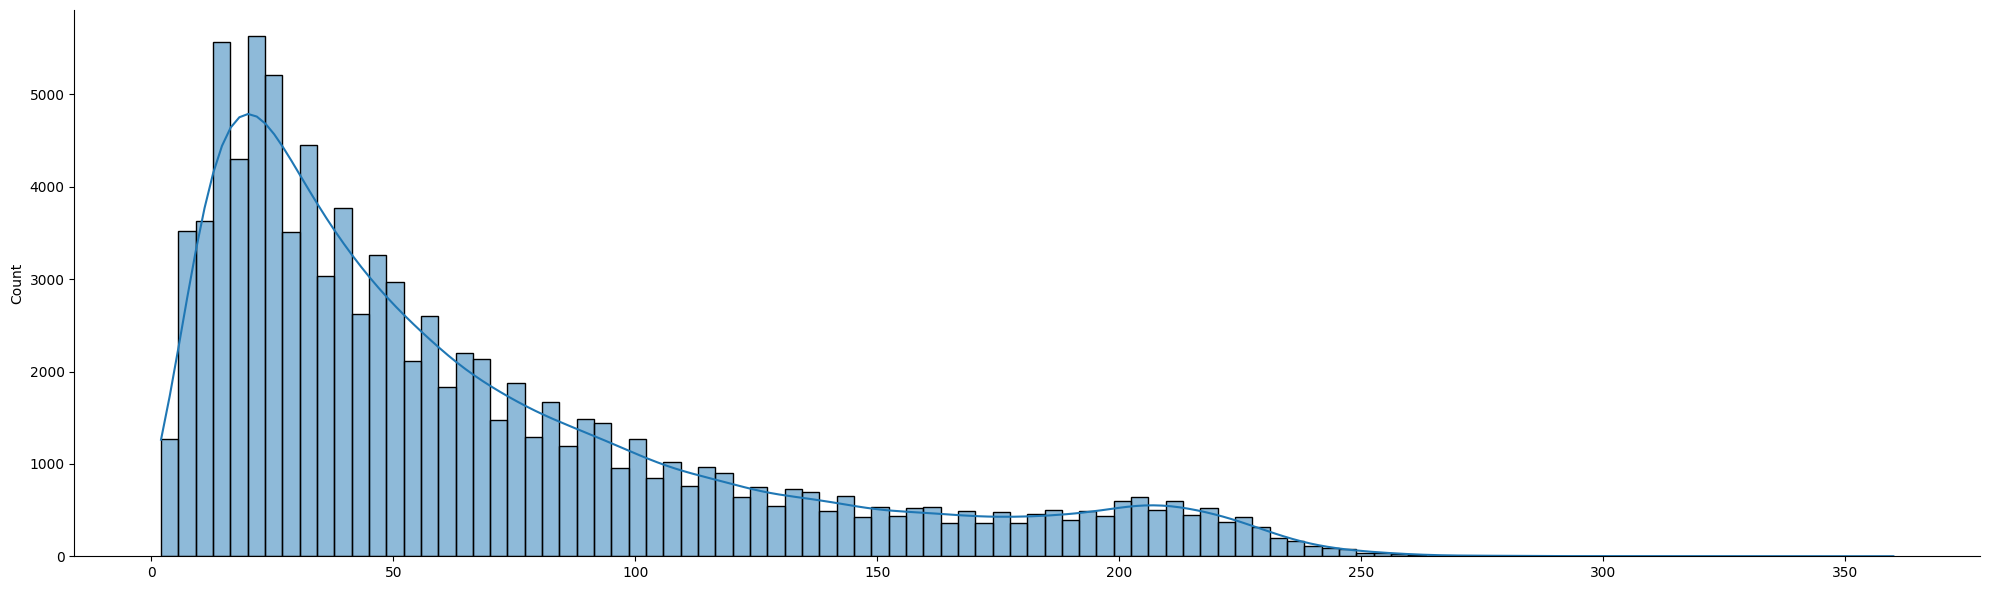

In [11]:
test_token_length = tokenizer(text=df_test['clean_text3'].tolist(), return_length=True).length
# 대다수 tokenizer는 list같은 기본형 구조만 받음. Series->list로 변환
# return_length=True: 토큰화 결과에 각 입력 문장의 토큰 개수 추가
# .length: 그 토큰 개수를 출력

# plt.figure(figsize=(20,6))
sns.displot(test_token_length, bins=100, kde=True, height=6, aspect=20/6)
plt.xticks(np.arange(0,400,50))
plt.show()

## Coverting to TFRecord type
* TPU에서는 데이터포멧으로 0, 1 이진형태로 표현된 TFRecord 형태를 권장함
* TPU 학습과는 별개로 진행 권장

### define converting function

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _float_array_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1)))

def serialize_train_example(input_ids, attention_mask, label):
    feature = {
        "input_ids": _bytes_feature(input_ids),
        "attention_mask": _bytes_feature(attention_mask),
        "label": _float_array_feature(label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def serialize_test_example(input_ids, attention_mask):
    feature = {
        "input_ids": _bytes_feature(input_ids),
        "attention_mask": _bytes_feature(attention_mask),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
class TFRecordGenerator:
    def __init__(
        self,
        dataset_type,
        texts,
        tokenizer,
        labels=None,
        max_len=220,
        chunk_size=100000,
        f_name="train.tfrecord",
        out_path="/kaggle/working",
    ):
        # Set parameters
        self.dataset_type = str(dataset_type).upper()
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.chunk_size = chunk_size
        self.tfrecord_file_path = os.path.join(out_path, f_name)
        self.data_size = len(self.texts)
        self._check_data()


    def _check_data(self):
        if self.dataset_type not in ("TRAIN", "TEST"):
            raise Exception("Dataset type is not valid: 'TRAIN' or 'TEST'")

        if self.dataset_type == "TRAIN":
            if len(self.labels) == 0:
                raise Exception("Label are not found for TRAIN SET")

            if len(self.texts) != len(self.labels):
                raise Exception("Texts and labels are different size.")

        elif self.dataset_type == "TEST":
            self.labels = None

        print(f"Generate {self.dataset_type} SET")
        print(f"output text shape: ({self.data_size}, {self.max_len})")

    def _encode(self, text_chunk):
        encoding_texts = self.tokenizer(
            text_chunk.tolist(),
            return_token_type_ids = False,
            return_attention_mask = True,
            padding = "max_length",
            max_length = self.max_len,
            truncation = True,
        )

        # token_id의 숫자범위가 0~65535 이내이므로 용량 절감을 위해 uint16 타입 적용
        input_ids = np.asarray(encoding_texts["input_ids"], dtype=np.uint16)
        attention_mask = np.asarray(encoding_texts["attention_mask"], dtype=np.bool_)
        return input_ids, attention_mask

    def _get_chunk(self):
        for i in range(0, self.data_size, self.chunk_size):
            text_chunk = self.texts[i:i+self.chunk_size]
            encoded_data = self._encode(text_chunk)

            if self.dataset_type == "TRAIN":
                label_chunk = self.labels[i:i+self.chunk_size]
            else:
                label_chunk = None

            yield (encoded_data, label_chunk)

    def make_tfrecord(self):
        with tf.io.TFRecordWriter(self.tfrecord_file_path) as writer:
            for encoded_data, label_chunk in tqdm(self._get_chunk()):
                input_ids, attention_mask = encoded_data
                chunk_size = len(input_ids)

                for i in range(chunk_size):
                    if self.dataset_type == "TRAIN":
                        sample = serialize_train_example(
                            input_ids[i].tobytes(),
                            attention_mask[i].tobytes(),
                            label_chunk[i],
                        )
                    else:
                        sample = serialize_test_example(
                            input_ids[i].tobytes(), attention_mask[i].tobytes()
                        )
                    writer.write(sample)

### Convert

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
save_path = "./bert_base_uncased/"
os.makedirs(save_path, exist_ok=True)
tokenizer.save_pretrained(save_path)

In [ ]:
# 전처리
def preprocess(df):
    df['comment_text'] = df['comment_text'].apply(ascii_text)
    
    url_pattern = r"https?://\S+|www\.\S+"
    df['comment_text'] = df['comment_text'].str.replace(url_pattern, " ", regex=True)
    df['comment_text'] = df['comment_text'].apply(simple_clean_text)

    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [ ]:
df_train['comment_text'].sample(20)

In [ ]:
# 변환
train_tfrec = TFRecordGenerator(
    dataset_type="TRAIN",
    texts=df_train['comment_text'].values,
    labels=df_train['target'].values,
    tokenizer=tokenizer,
    max_len=220,
    chunk_size=250000,
    f_name='train.tfrecord',
    out_path='/kaggle/working/',
)
train_tfrec.make_tfrecord()

test_tfrec = TFRecordGenerator(
    dataset_type="TEST",
    texts=df_test['comment_text'].values,
    tokenizer=tokenizer,
    max_len=220,
    chunk_size=100000,
    f_name='test.tfrecord',
    out_path='/kaggle/working/',
)
test_tfrec.make_tfrecord()